<a href="https://colab.research.google.com/github/aldisstar/Taller-MIT/blob/main/Example_2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingredients for a Good Neural Network

Make sure you change runtime type to GPU! Today is computationally intensive.

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data_utils

!pip install livelossplot
!pip install pytorchtools

# data manipulation
import pandas as pd
import numpy as np
from livelossplot import PlotLosses

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed
import multiprocessing

import warnings
warnings.filterwarnings("ignore")

random_seed = 1
torch.manual_seed(random_seed)

## Get Device for Training

We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the CPU.

## You can use a free GPU/TPU through CoLab (if available) for faster training!

Go to Runtime --> Change runtime type --> GPU or TPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### MNIST Hand digits Dataset

This is the same dataset we used yesterday. Recall that there are 10 classes/digits that we're trying to identify.


In [ ]:
train_indices = torch.arange(2500)
# tr_10k = data_utils.Subset(tr, indices)

train_set = data_utils.Subset(torchvision.datasets.MNIST('sample_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), train_indices)


test_indices = torch.arange(250)
test_set = data_utils.Subset(torchvision.datasets.MNIST('sample_data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), test_indices)


# make validation set by splitting train set
indices = [i for i in range(2500)]  # using a smaller dataset to see training in action
rand1, rand2 = train_test_split(indices, test_size=0.2, random_state=1, shuffle=True)

train_sample = SubsetRandomSampler(rand1)
val_sample = SubsetRandomSampler(rand2)

batch_size=64
# create data loaders
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sample, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(train_set, sampler=val_sample, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 275786957.77it/s]

Extracting sample_data/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57058734.73it/s]


Extracting sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77744206.71it/s]

Extracting sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8275642.38it/s]

Extracting sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST/raw



# Recap of yesterday

## Simple NN example model

### Create network & forward pass

In [ ]:
class FullyConnectedNetwork(nn.Module):
  def __init__(self, n_features=784, hidden_size=32):
    super().__init__()
    self.layer0 = nn.Linear(n_features, hidden_size)

    # Add a linear output layer with 10 neurons
    self.layer1 = nn.Linear(hidden_size, 10)

  def forward(self, input_data):
    # Apply ReLU activation after 1st input layer
    x = F.relu(self.layer0(input_data))

    # Apply 2nd layer
    x = self.layer1(x)

    # Apply log_softmax activation for last layer & then return outputs
    return F.log_softmax(x)

### Set hyperparameters, create model instance, set optimizer

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [ ]:
# Create an instance of the above NN
fc_network = FullyConnectedNetwork()

# Pass model to device (CPU or GPU)
fc_network.to(device)

# Set SGD optimizer with learning rate & momentum
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate, momentum=momentum)

# Print model architecture
print(fc_network)

FullyConnectedNetwork(
  (layer0): Linear(in_features=784, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=10, bias=True)
)


### Training loop

In [ ]:
# Note: network.train() puts the network into "nondeterministic mode".
# This doesn't matter for the fully connected network, but will matter for the convolutional network
def train(network, optimizer, epoch, flatten_data=True):
  network.train()
  loss_logs = list()

  for batch_idx, (data, target) in enumerate(train_loader):
    if flatten_data:
      data = flatten(data)

    num_batches = len(trainloader)
    size = len(trainloader.dataset)

    # To account for GPU
    data, target = data.to(device), target.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    output = network(data)

    # Compute loss with negative log likelihood loss function
    loss = F.nll_loss(output, target)

    # Perform backpropagation - compute/update gradient
    loss.backward()

    # Perform optimization
    optimizer.step()

    # print an update
    if batch_idx % log_interval == 0:
      examples_shown = batch_idx * len(data)
      total_examples = len(train_loader.dataset)
      fraction_shown = round(examples_shown / total_examples * 100., 2)
      rounded_loss = round(loss.item(), 4)
      print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

      examples_so_far = batch_idx*batch_size_train + epoch*len(train_loader.dataset)
      loss_logs.append((examples_so_far, loss.item()))
  return loss_logs

## More complex CNN model & forward pass

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input image channel, 10 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # Add another convolutional layer with 20 output channels & 5x5 kernel
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # Add dropout
        self.conv2_drop = nn.Dropout2d()

        # Add linear layer with 320 inputs & 50 outputs
        self.fc1 = nn.Linear(320, 50)

        # Add linear layer with 50 inputs & 10 outputs
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Apply the 2nd Conv layer followed by dropout
        x = self.conv2_drop(self.conv2(x))

        # Apply max pooling with size of the pooling region (kernel) = 2
        x = F.max_pool2d(x, 2)

        # Apply ReLU activation
        x = F.relu(x)

        x = x.view(-1, 320)

        # Apply the 1st linear layer
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)

        # Apply the last linear layer
        x = self.fc2(x)

        # Return categorical probability distribution (calculate log(softmax))
        return F.log_softmax(x)

# **Today's code**

In [ ]:
!# Fully connected networks can't take 2D images as input, so we flatten images into long vectors
def flatten(batch):
  flat_batch = batch.reshape((batch.shape[0], 784))
  return flat_batch

### Create function to create neural network with desired depth and width

In [ ]:
from torch.nn import ModuleList, Sequential, Linear, ReLU, Softmax, CrossEntropyLoss

class FullyConnectedNetwork(nn.Module):
  def __init__(self,  hidden_layers=2, hidden_nodes=10):
    super().__init__()
    layers = list()

    # Add linear input layer
    layers.append(Linear(784, hidden_nodes))

    # Add ReLU activation function
    layers.append(ReLU())

    # Create all hidden layers with n_hidden neurons each
    for _ in range(hidden_layers):
      # Add hidden layers with ReLU activation
      layers.append(Linear(hidden_nodes, hidden_nodes))
      layers.append(ReLU())

    # Add linear output layer
    layers.append(Linear(hidden_nodes, 10))

    # chain together
    self.mlp = Sequential(*layers)

  def forward(self, input_data):
    return self.mlp(input_data)

## Training and Testing Functions for today

In [ ]:
def trainer(network, optimizer, device, flatten_data=True):
  network.train()

  # initiate for epoch accuracy/loss
  total_loss = 0
  total_correct = 0
  total_items = 0

  for batch_idx, (data, target) in enumerate(train_loader):

    # send to GPU for speedy boi
    data, target = data.to(device), target.to(device)

    if flatten_data:
      data = flatten(data)

    # get prediction
    output = network(data)

    # calculate batch loss
    loss_fn = CrossEntropyLoss()
    loss = loss_fn(output, target)

    # Clear gradient,  update
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Gradient update step
    optimizer.step()

    # update loss and accuracy
    total_loss += loss
    total_correct += torch.sum( torch.argmax(output, dim=1)==target)
    total_items += len(target)

    # Compute loss and accuracy as ratios
    loss_ratio = (total_loss/total_items).item()
    correct_ratio = (total_correct/total_items).item()

    # NOTE: .item() here moves the data from the GPU to CPU, since numpy only works with CPUs.

  return loss_ratio, correct_ratio

In [ ]:
def tester(network, loader, device, flatten_data=True):

  network.eval()

  # initiate for epoch accuracy/loss
  test_loss = 0
  test_correct = 0
  test_items = 0

  with torch.no_grad():
    for data, target in loader:

      # send to GPU for speedy boi
      data, target = data.to(device), target.to(device)

      if flatten_data:
        data = flatten(data)

      # get prediction
      output = network(data)

      # calculate batch loss
      loss_fn = CrossEntropyLoss()
      loss = loss_fn(output, target)

      # update loss and accuracy
      test_loss += loss
      test_correct += torch.sum(torch.argmax(output, dim=1) == target)
      test_items += len(target)

      # Compute loss and accuracy as ratios
      loss_ratio = (test_loss/test_items).item()
      correct_ratio = (test_correct/test_items).item()

  return loss_ratio, correct_ratio

## Let's see some overfitting in action!

### **Exercise 1**: Play with the number of epochs, number of hidden layers, and the hidden layer sizes until you see overfitting.

Disclaimer: it takes quite a few epochs = more time to see overfitting. We are looking for an upperward trend in the validation set.

*SOLUTION: I saw a pretty good trend with 3 hidden layers, 250 hidden nodes, and 50 epochs.*

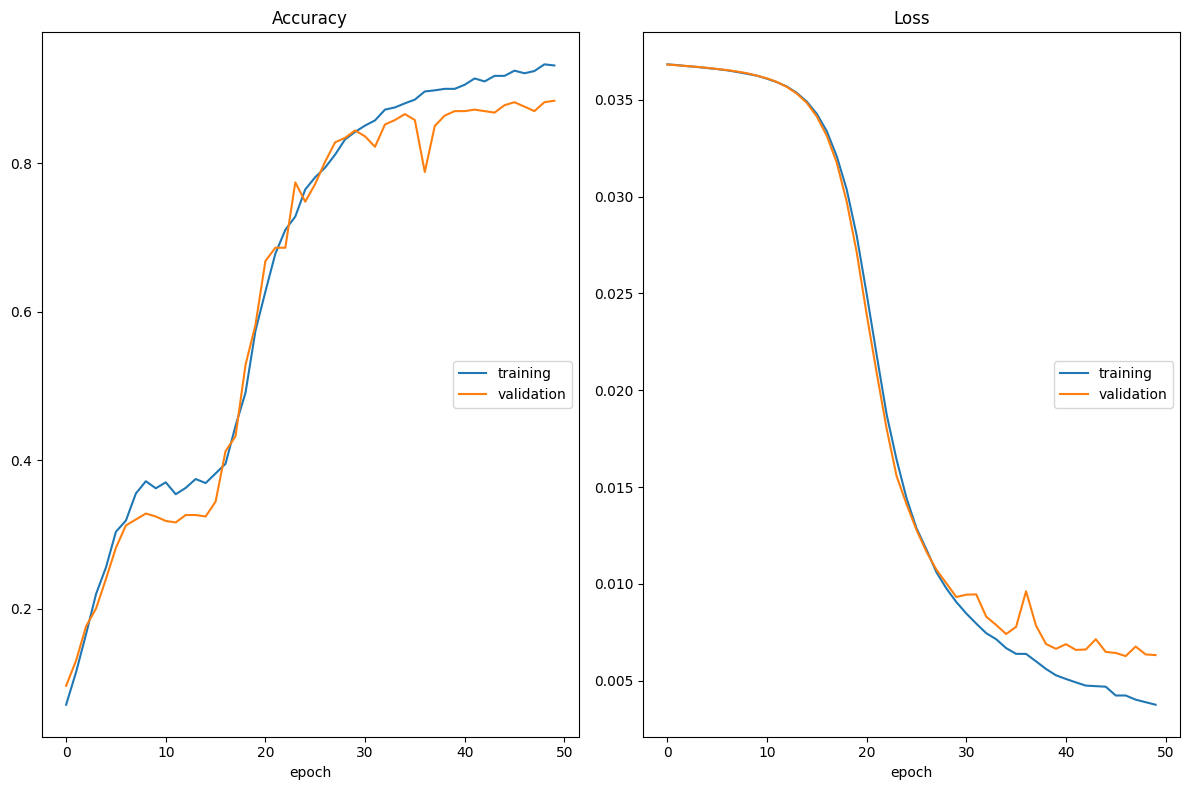

Accuracy
	training         	 (min:    0.071, max:    0.933, cur:    0.932)
	validation       	 (min:    0.096, max:    0.884, cur:    0.884)
Loss
	training         	 (min:    0.004, max:    0.037, cur:    0.004)
	validation       	 (min:    0.006, max:    0.037, cur:    0.006)


In [ ]:
plotlosses = PlotLosses()

# TODO: change n_epochs, hidden_layers and hidden_nodes to see overfitting!
learning_rate = 0.01
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers = 3, hidden_nodes = 250)
fc_network.to(device)
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate)

for epoch in range(n_epochs):

  train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc


#### Let's see how we do on the test set!

In [ ]:
test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

Test loss = 0.0066, Test Accuracy = 0.872


## Section 1.1: Let's try adding in some regularization!

### **Exercise 2**: What form of regularization does Pytorch use in the SGD optimizer by default - L1 or L2? Read the documentation here: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html. Why do you think they would use this form of regularization for neural networks?


*SOLUTION: PyTorch uses L2 regularization. This could be for a few reasons, but L1 is generally better for model interpretablility since it promotes sparse solutions. However, NN are inherently bad for interpretability, so might as well use a differentiable loss.*

### **Exercise 3**: Implement weight_decay in the SGD optimizer. Re-run the network with the following parameters: 3 hidden layers, 250 hidden nodes, 0.01 learning rate, and 50 epochs. How does changing weight_decay affect training? Play with the weight_decay strength and see how the plots qualitatively change.

*SOLUTION: Shouldn't see much, if any, overfitting as the weight decay increases. However, if it increases to much, network has trouble learning.*

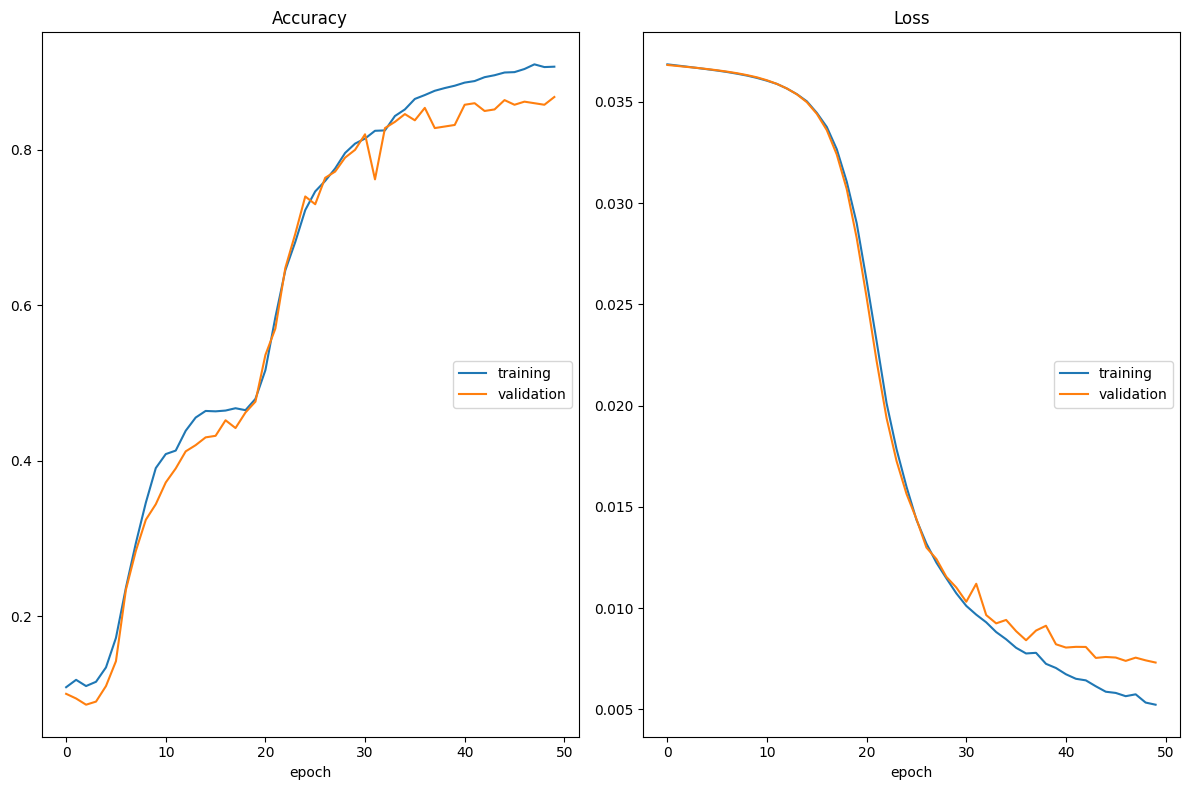

Accuracy
	training         	 (min:    0.109, max:    0.910, cur:    0.907)
	validation       	 (min:    0.086, max:    0.868, cur:    0.868)
Loss
	training         	 (min:    0.005, max:    0.037, cur:    0.005)
	validation       	 (min:    0.007, max:    0.037, cur:    0.007)


In [ ]:
plotlosses = PlotLosses()

weight_decay = 0.01 #### # 0.005

# create network and optimizer
learning_rate = 0.01
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers=3, hidden_nodes = 250)
fc_network.to(device)
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(n_epochs):
  train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

In [ ]:
test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

Test loss = 0.0076, Test Accuracy = 0.864


## Section 1.2: Now let's try adding some dropout

Documentation for syntax: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [ ]:
from torch.nn import Dropout

class DropoutNetwork(nn.Module):
  def __init__(self,  hidden_layers=2, hidden_nodes=10, p=0.1):
    super().__init__()

    layers = list()
    layers.append(Linear(784, hidden_nodes))            # input layer
    layers.append(ReLU())

    for _ in range(hidden_layers):                   # create hidden layers
      layers.append(Linear(hidden_nodes, hidden_nodes))

      # TODO: Add dropout layer with probability = p
      layers.append(Dropout(p=p))

      layers.append(ReLU())

    layers.append(Linear(hidden_nodes, 10))             # output layer

    self.mlp = Sequential(*layers)                      # chain together

  def forward(self, input_data):
    return self.mlp(input_data)

### **Exercise 4 and 5**

First, initialize the DropoutNetwork model using the same parameters you found from Exercise 3 - do you still see overfitting?

Then, play with the $p$ parameter ($0 \leq p \leq 1$). What do you qualitatively see in the loss plot as you increase $p$ (i.e. closer to 1)?

SOLUTION: As $p$ approaches 1, should be increasingly harder for network to learn. Also, lines get more squiggly since randomly shutting off node with greater probability makes model more volatile/unstable resulting in more fluctuations between iterations.

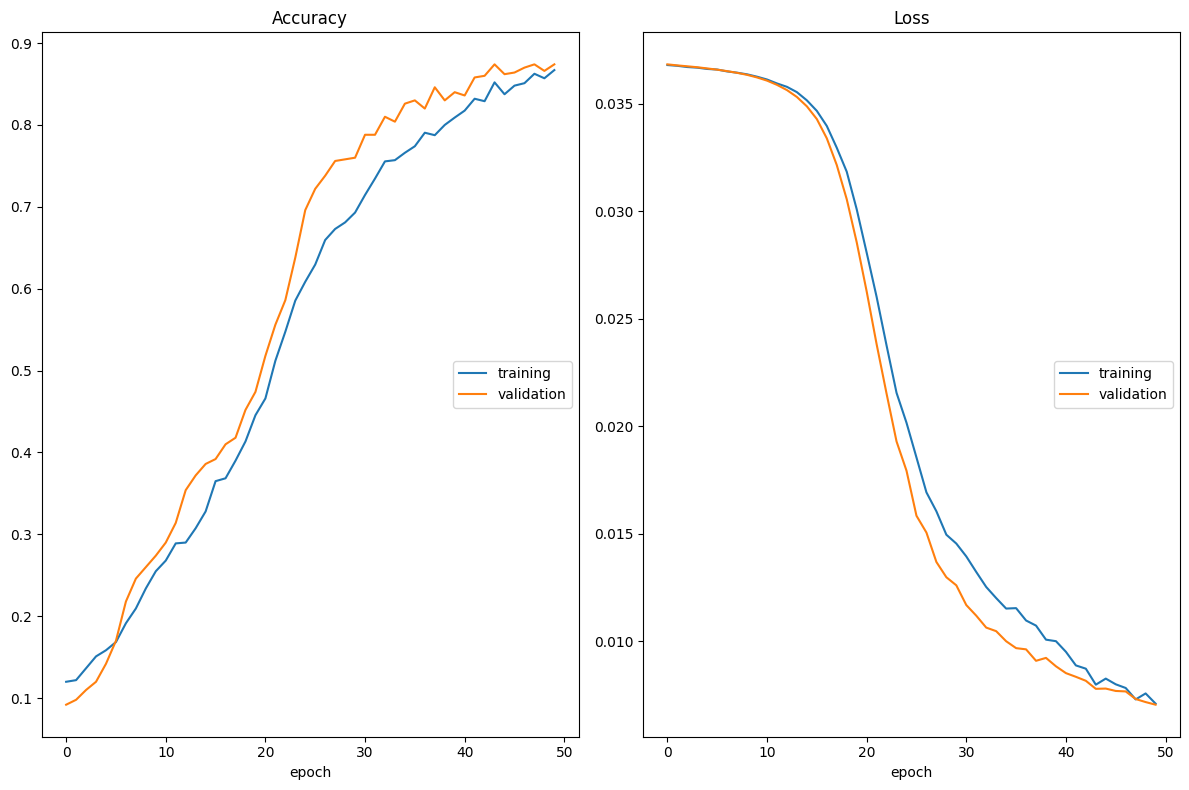

Accuracy
	training         	 (min:    0.120, max:    0.867, cur:    0.867)
	validation       	 (min:    0.092, max:    0.874, cur:    0.874)
Loss
	training         	 (min:    0.007, max:    0.037, cur:    0.007)
	validation       	 (min:    0.007, max:    0.037, cur:    0.007)


In [ ]:
plotlosses = PlotLosses()

p = 0.3 ####

# create network and optimizer
learning_rate = 0.01
n_epochs = 50

# Create DropoutNetwork with same NN parameters from Exercise 3 (example with overfitting)
drop_network = DropoutNetwork(hidden_layers=3, hidden_nodes = 250, p=p)

drop_network.to(device)

drop_optimizer = optim.SGD(drop_network.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
  train_loss, train_acc = trainer(drop_network, drop_optimizer, device)
  val_loss, val_acc = tester(drop_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

In [ ]:
test_loss, test_acc = tester(drop_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

Test loss = 0.0072, Test Accuracy = 0.868


## Section 1.3: Create training loop to use early stopping callback

The key parameter to adjust here is `Patience` = this is the number of epochs to wait for if there's no improvement in validation performance/loss before stopping the training.

### **Exercise 6**: Initialize a FullyConnectedNetwork model from Exercise 1 using the same parameters from previous exercises. Play with different patience values to see how it affects validation accuracy. What do you notice as you increase the patience value? Are you able to reduce the overfitting issue using this method?

*SOLUTION*: Too small values of patience will cause training to terminate prematurely resulting in low training & validation accuracy due to underfitting. However, too high values of patience may prevent the algorithm from stopping quickly enough, resulting in lower validation performance due to overfitting.

Here, we find that using an intermediate patience of 4 epochs is able to reduce the overfitting issue and improve the validation accuracy over the previous methods.

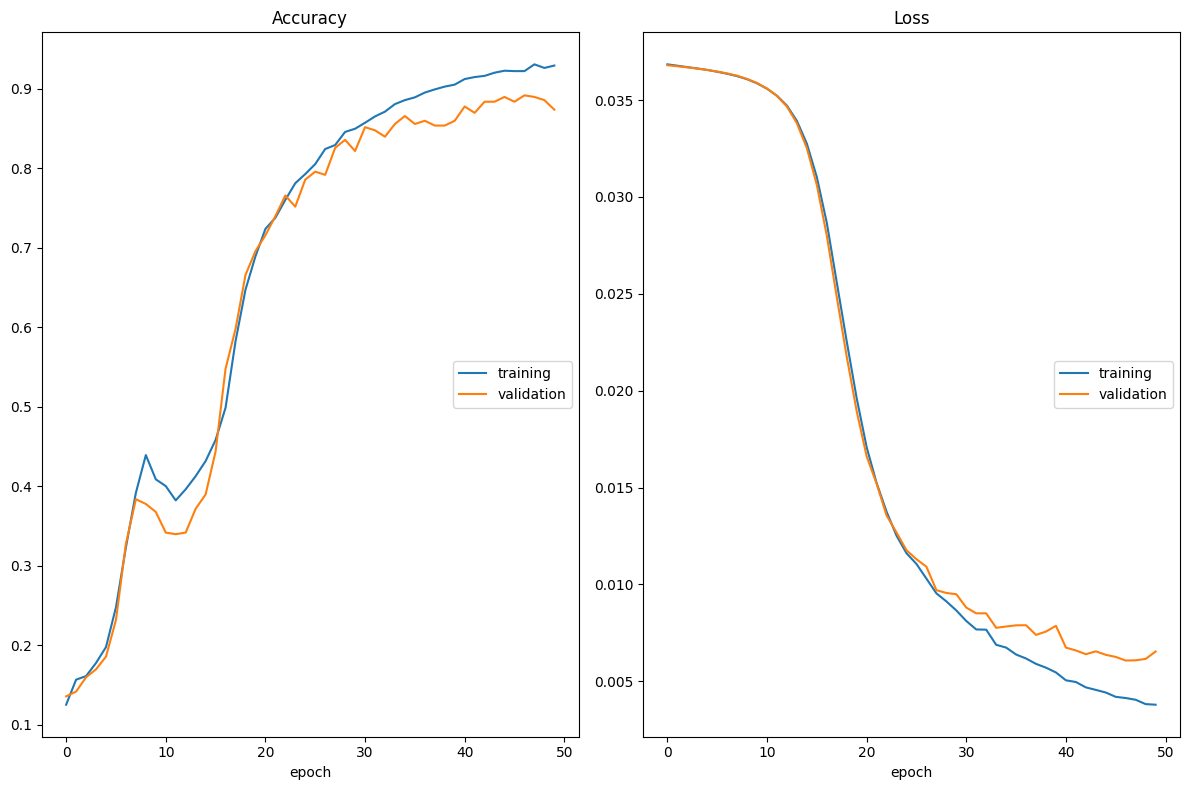

Accuracy
	training         	 (min:    0.126, max:    0.931, cur:    0.930)
	validation       	 (min:    0.136, max:    0.892, cur:    0.874)
Loss
	training         	 (min:    0.004, max:    0.037, cur:    0.004)
	validation       	 (min:    0.006, max:    0.037, cur:    0.007)
The Current Loss: 0.00653258478268981
Trigger Times: 3


In [ ]:
learning_rate = 0.01
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers = 3, hidden_nodes = 250)
fc_network.to(device)
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate)

patience = 4 # Try values 1, 2, 3, 4, 5

plotlosses = PlotLosses()
# Train 1st epoch separately
train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
val_loss, val_acc = tester(fc_network, val_loader, device)

plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
plotlosses.draw()  # draw, update logs, etc

# Early stopping
last_loss = val_loss
triggertimes = 0

# Train remaining epochs
for epoch in range(1, n_epochs):

  # Save latest model
  latest_model = fc_network

  train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

  current_loss = val_loss

  print('The Current Loss:', current_loss)

  if current_loss > last_loss:

      trigger_times += 1
      print('Trigger Times:', trigger_times)

      if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          break

  else:
    print('trigger times: 0')
    trigger_times = 0

  last_loss = current_loss

In [ ]:
test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

Test loss = 0.0068, Test Accuracy = 0.876


## Section 1.4: Modify learning rate and optimizer

We won't be covering it here but you can also set a desired time-varying learning rate schedule as well, using the `torch.optim.lr_scheduler` option in PyTorch.

You can learn about the different types of optimizers and learning rate schedulers available in PyTorch [here](https://https://pytorch.org/docs/stable/optim.html).

### **Exercise 7**: Experiment with different optimization algorithms and learning rates to see how it affects **training time and accuracy**. Compare the **convergence time** to the runs above.

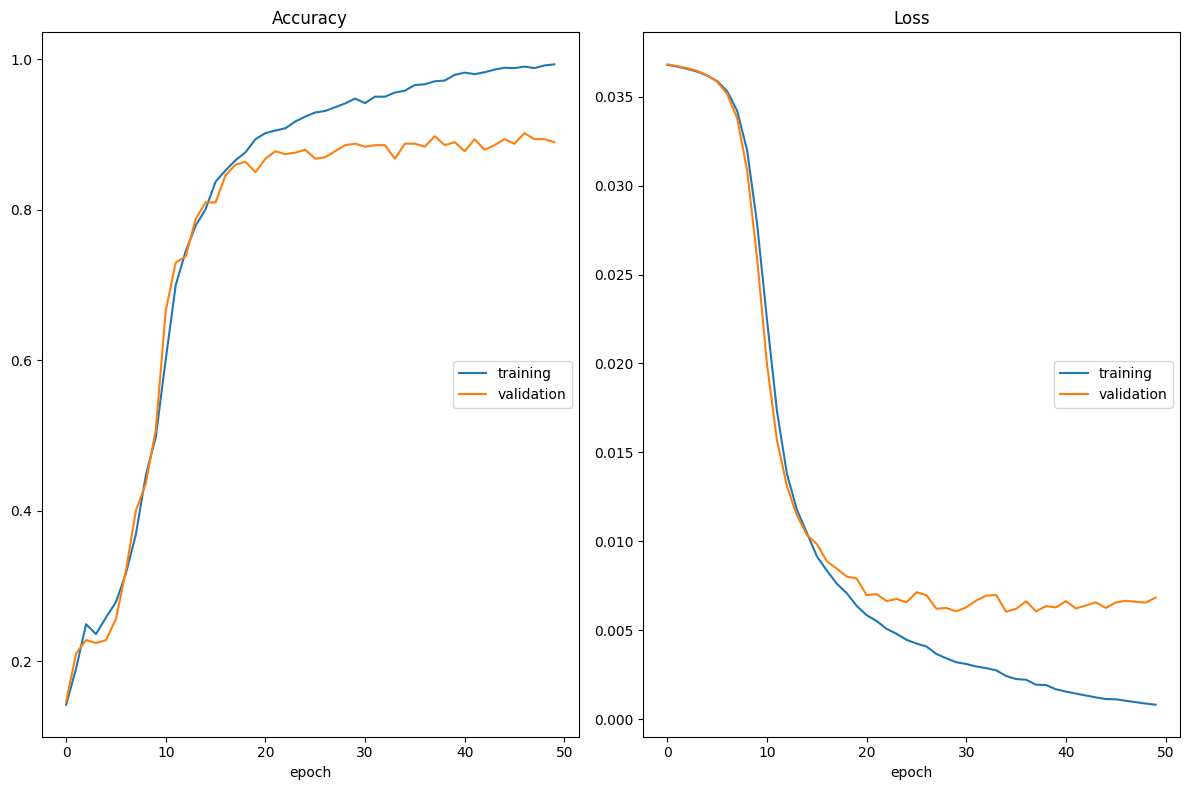

Accuracy
	training         	 (min:    0.142, max:    0.994, cur:    0.994)
	validation       	 (min:    0.146, max:    0.902, cur:    0.890)
Loss
	training         	 (min:    0.001, max:    0.037, cur:    0.001)
	validation       	 (min:    0.006, max:    0.037, cur:    0.007)
CPU times: user 56.9 s, sys: 8 s, total: 1min 4s
Wall time: 57.8 s


In [ ]:
# Record convergence time
%%time

plotlosses = PlotLosses()

learning_rate = 0.01
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers = 3, hidden_nodes = 250)
fc_network.to(device)

# Add momentum term
momentum = 0.5

# Try out different optimizers {SGD, Adam, RMSprop, Adadelta}
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(n_epochs):

  train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc


In [ ]:
test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

Test loss = 0.006, Test Accuracy = 0.9


### **Optional**: Try using an exponential learning rate schedule with `torch.optim.lr_scheduler.ExponentialLR`.

## Section 1.5: Now let's add: Batch-Normalization!

Documentation for syntax: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d

In [ ]:
from torch.nn import BatchNorm1d

class BatchNormNetwork(nn.Module):
  def __init__(self,  hidden_layers=2, hidden_nodes=10):
    super(BatchNormNetwork, self).__init__()
    layers = list()

    layers.append(Linear(784, hidden_nodes))            # input layer
    layers.append(ReLU())
    for hdim in range(hidden_layers):                   # create hidden layers
      layers.append(Linear(hidden_nodes, hidden_nodes))
      layers.append(ReLU())

      # Add 1D batch normalization to all hidden nodes
      # Append BatchNorm1d layer
      layers.append(BatchNorm1d(hidden_nodes))

    layers.append(Linear(hidden_nodes, 10))             # output layer

    self.mlp = Sequential(*layers)                      # chain together

  def forward(self, input_data):
    return self.mlp(input_data)

### **Exercise 8**: Play with batch normalization to see how it affects **training time and accuracy**. Compare the **convergence time** to the runs above.

*SOLUTION: Should see the training and validation converge much quicker compared to a non-batch normed network. For example, I got 0 loss and 100% accuracy within 25 epochs with 2 hidden layers and 100 hidden nodes.*

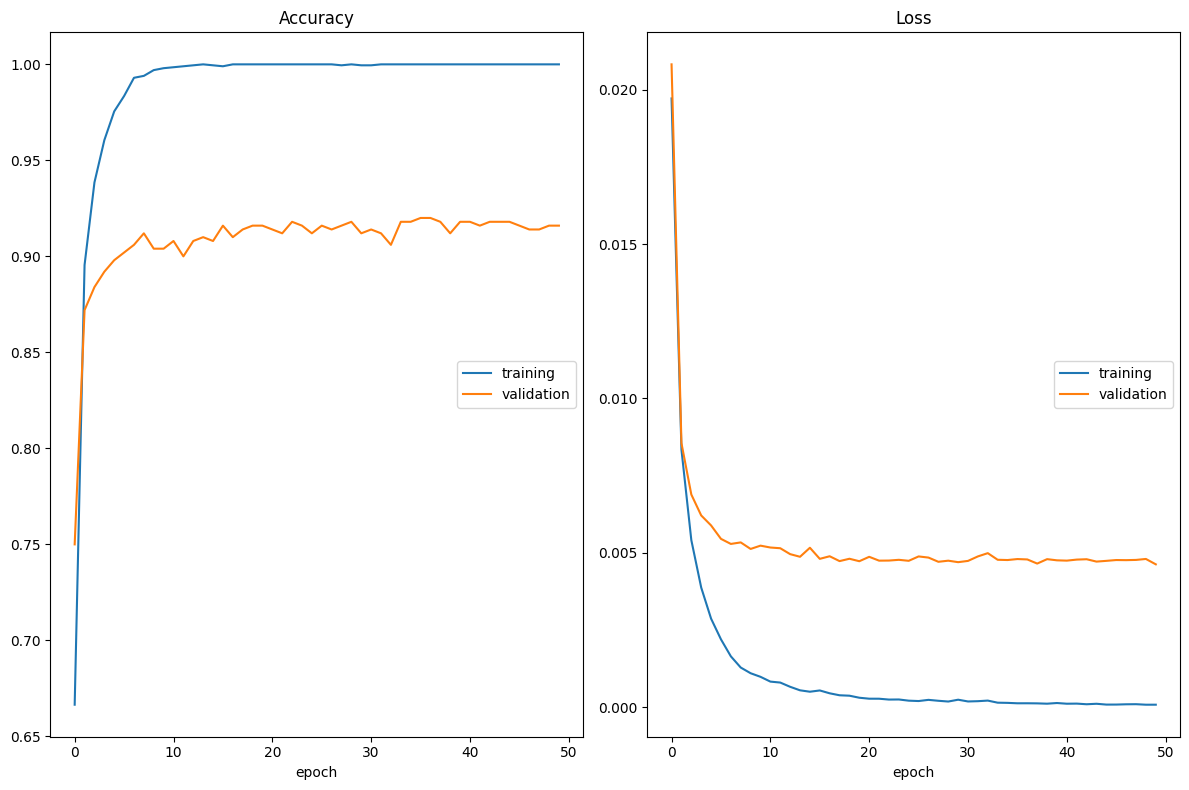

Accuracy
	training         	 (min:    0.667, max:    1.000, cur:    1.000)
	validation       	 (min:    0.750, max:    0.920, cur:    0.916)
Loss
	training         	 (min:    0.000, max:    0.020, cur:    0.000)
	validation       	 (min:    0.005, max:    0.021, cur:    0.005)
CPU times: user 57.9 s, sys: 8.12 s, total: 1min 5s
Wall time: 58.2 s


In [ ]:
# Record convergence time
%%time

plotlosses = PlotLosses()

# create network and optimizer
learning_rate = 0.01
n_epochs = 50

# Create BatchNormNetwork with same NN parameters from Exercise 1 (for which you saw overfitting)
batch_network = BatchNormNetwork(hidden_layers=3, hidden_nodes = 250)

batch_network.to(device)

batch_optimizer = optim.SGD(batch_network.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
  train_loss, train_acc = trainer(batch_network, batch_optimizer, device)
  val_loss, val_acc = tester(batch_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

In [ ]:
test_loss, test_acc = tester(batch_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

### **Exercise 9**: Try to build the best model (measured by test accuracy) using your own combination of 2 or more of the above techniques! For the best best model, you'll need the whole dataset, but that will take longer to train.

#### Add the code for your network and training loop here!

### What was the highest training accuracy you could achieve? What methods and hyperparameter values did you use?